### 1. Align MOD021KM and MOD35 for clustreing on NZ test region
### 2. Tests clustering results with and without using DNN
### 3. Check status value
Necessary to develop compute `mode` for cloud-type

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import copy
import glob
import numpy as np
import scipy as sc
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC 
from sklearn.cluster import AgglomerativeClustering
from matplotlib import patches as mpl_patches
from os import listdir
from os.path import isfile, join

In [2]:
filedir = "/home/rubywerman/clouds/src_analysis/labeled_data/"

In [3]:
class Patch:        
    def __init__(self, date, isOpen, thirtyFive, zeroTwo, label=None, feature=None, has_coord=False, coords=None):
        self.date = date
        self.isOpen = isOpen
        self.thirtyFive = thirtyFive
        self.zeroTwo = zeroTwo
        self.label = label
        self.feature = feature
        self.has_coord = has_coord
        self.coords = coords
        
    def print_attr(self):
        print("date: " + self.date)
        print("isOpen: " + str(self.isOpen))
        print("label: " + str(self.label))
        if len(self.coords) > 0:
            print("coords: ")
            for i in self.coords:
                print(str(i))

In [4]:
def get_files(path, path1=None):
    if path1:
        return [f for f in listdir(path) if isfile(join(path, f))] + [f for f in listdir(path1) if isfile(join(path1))]
    else:
        return [f for f in listdir(path) if isfile(join(path,f))]

def get_dates(files):
    just_dates = [f[10:17] for f in files]
    just_dates_unique = set()
    for d in just_dates:
        just_dates_unique.add(d)
    return list(just_dates_unique)

In [5]:
#returns the coded date in the format of year, and days after January 1st
#e.g. January 1, 2001 -- > 2001015
def get_coded_date(date):
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days_per_month_leap = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    leap_years = [2000, 2004, 2008, 2012]
    year = int(date[0:4])
    month = int(date[5:7])
    day = int(date[8:])
    days = day
    if month != 1:
        calendar = days_per_month
        if year in leap_years:
            calendar = days_per_month_leap
        for m in range(month - 1):
            days += calendar[m]
    return str(year * 1000 + days)

In [6]:
#class_patch_list contains labeled patches with their date, mod02, and mod35 data
class_patch_list = np.load(filedir + 'class_patch_data/071619.npy')
dates = [patch.date for patch in class_patch_list]
mod06_path1 = "/project2/foster/clouds/data/MOD06"
mod06_path2 = "/project2/foster/clouds/data/MOD06_part2"
mod06_files = get_files(mod06_path1, mod06_path2)
mod06_dates = [int(d) for d in get_dates(mod06_files)]                                     

In [7]:
df = pd.DataFrame(dates, columns=["labeled date"])
df = pd.DataFrame(df["labeled date"].unique(), columns=["labeled date"])
coded_dates = [get_coded_date(d) for d in df["labeled date"]]
df["coded date"] = coded_dates
df

,labeled date,coded date
0,2012-06-13,2012165
1,2013-07-09,2013190
2,2008-09-12,2008256
3,2005-06-24,2005175
4,2011-07-15,2011196
5,2007-09-26,2007269
6,2007-11-18,2007322


In [8]:
sys.path.insert(1,os.path.join(sys.path[0],"/home/rubywerman/scratch-midway2/lib_hdfs/"))
from lib_modis02 import proc_sds
from alignment_lib import  decode_cloud_flag, const_clouds_array
from analysis_lib import _get_colors, _gen_patches

In [9]:
#sys.path.insert(1,os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD35"))
#from alignment_lib import  decode_cloud_flag, const_clouds_array

In [10]:
#sys.path.insert(1, os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD06/" ) )
#from analysis_lib import _get_colors, _gen_patches

#### Load Cloud Flag data

In [11]:
mod35_datadir = '/home/rubywerman/scratch-midway2/lib_hdfs/mod35/open_chile_3/'

In [52]:
len("/home/rubywerman/scratch-midway2/lib_hdfs/mod35/open_chile_3//2013-07-10/MOD35_L2.")

82

In [67]:
mod35_filelist = glob.glob(mod35_datadir+"/2013-07-10/*.hdf")

#mod35_filelist = glob.glob("../tak_data/MOD35/*.hdf")
mod35_filelist.sort()

In [13]:
[os.path.basename(i) for i in mod35_filelist]

['MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_000501344918.Cloud_Mask_1.hdf',
 'MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_000501344918.Cloud_Mask_2.hdf',
 'MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_000501344918.Cloud_Mask_3.hdf',
 'MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_000501344918.Cloud_Mask_4.hdf',
 'MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_000501344918.Cloud_Mask_5.hdf',
 'MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_000501344918.Cloud_Mask_6.hdf',
 'MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_000501344918.Cloud_Mask_SPI.hdf',
 'MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_000501344918.Quality_Assurance.hdf',
 'MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_000501344918.Scan_Start_Time.hdf',
 'MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_000501344918.Sensor_Azimuth.hdf',
 'MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_000501344918.Sensor_Zenith.hdf',
 'MOD35_L2.A2013191.mosaic.061.2019162191127.mcgscs_00050134491

In [14]:
hdf_cm1 = SD(mod35_filelist[0], SDC.READ)

In [15]:
cm1_sds = hdf_cm1.select('Cloud_Mask')

In [16]:
cloud_mask_array = decode_cloud_flag(cm1_sds)

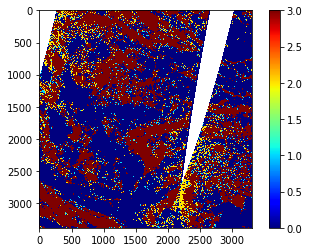

In [17]:
### check cloud mask 
plt.imshow(cloud_mask_array, cmap='jet')
plt.colorbar()

#### Model

In [18]:
#datadir = "/project2/foster/clouds/output/mod02/m2_02_global_2000_2018_band28_29_31"
datadir = '/home/rubywerman/scratch-midway2/lib_hdfs/model/m2_02_global_2000_2018_band28_29_31'
#from /project2/foster/clouds/model/m2_02_global_2000_2018_band28_29_31
#datadir = "../model_m2_02"

In [19]:
# step
step = 100000

# model
encoder_def = datadir+'/encoder.json'
encoder_weight = datadir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

W0719 13:11:56.366934 140568818517824 deprecation.py:506] From /home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0719 13:11:56.368999 140568818517824 deprecation.py:506] From /home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
/home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:891: UserWarning: models is not loaded, but a Lambda layer uses it.

#### MOD02

In [20]:
#hdf_datadir = "/project2/chard/clouds/data/MOD02/04"
#from /project2/foster/clouds/data/shared/test_img/MOD02/20150628
hdf_datadir = '/home/rubywerman/scratch-midway2/lib_hdfs/mod02/open_chile_3/'
#hdf_datadir = "../tak_data/MOD02"

In [21]:
mod02_filelist = glob.glob(hdf_datadir+"/2013-07-10/*.hdf")
#mod35_filelist = glob.glob("../tak_data/MOD35/*.hdf")
mod02_filelist.sort()

[os.path.basename(i) for i in mod02_filelist]

['MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.Band_1KM_Emissive.hdf',
 'MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.Band_1KM_RefSB.hdf',
 'MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.Band_250M.hdf',
 'MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.Band_500M.hdf',
 'MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.Change_in_relative_responses_of_thermal_detectors.hdf',
 'MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.DC_Restore_Change_for_Reflective_1km_Bands_1.hdf',
 'MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.DC_Restore_Change_for_Reflective_1km_Bands_10.hdf',
 'MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.DC_Restore_Change_for_Reflective_1km_Bands_100.hdf',
 'MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.DC_Restore_Change_for_Reflective_1km_Bands_101.hdf',
 'MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.DC_Resto

In [22]:
hdf_filelist=[
    hdf_datadir+"/2013-07-10/"+'/MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.EV_500_Aggr1km_RefSB_4.hdf',
    hdf_datadir+"/2013-07-10/"+'/MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.EV_500_Aggr1km_RefSB_5.hdf',
    hdf_datadir+"/2013-07-10/"+'/MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.EV_1KM_Emissive_1.hdf',
    hdf_datadir+"/2013-07-10/"+'/MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.EV_1KM_Emissive_8.hdf',
    hdf_datadir+"/2013-07-10/"+'/MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.EV_1KM_Emissive_9.hdf',
    hdf_datadir+"/2013-07-10/"+'/MOD021KM.A2013191.mosaic.061.2019158033103.mcgscs_000501343567.EV_1KM_Emissive_11.hdf'
]

In [23]:
b6_hdf = SD(hdf_filelist[0], SDC.READ)
b7_hdf = SD(hdf_filelist[1], SDC.READ)
b20_hdf = SD(hdf_filelist[2], SDC.READ)
b28_hdf = SD(hdf_filelist[3], SDC.READ)
b29_hdf = SD(hdf_filelist[4], SDC.READ)
b31_hdf = SD(hdf_filelist[5], SDC.READ)

In [24]:
b6_sds = b6_hdf.select("EV_500_Aggr1km_RefSB")
b7_sds = b7_hdf.select("EV_500_Aggr1km_RefSB")
b20_sds = b20_hdf.select("EV_1KM_Emissive")
b28_sds = b28_hdf.select("EV_1KM_Emissive")
b29_sds = b29_hdf.select("EV_1KM_Emissive")
b31_sds = b31_hdf.select("EV_1KM_Emissive")

In [25]:
b6_array, b6 = proc_sds(b6_sds)
b7_array, b7 = proc_sds(b7_sds)
b20_array, b20 = proc_sds(b20_sds)
b28_array, b28 = proc_sds(b28_sds)
b29_array, b29 = proc_sds(b29_sds)
b31_array, b31 = proc_sds(b31_sds)

Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31


In [26]:
nx, ny = b6_array.shape

In [27]:
d_list = [
    b6_array.reshape(nx,ny,1),
    b7_array.reshape(nx,ny,1),
    b20_array.reshape(nx,ny,1),
    b28_array.reshape(nx,ny,1),
    b29_array.reshape(nx,ny,1),
    b31_array.reshape(nx,ny,1),
]

In [28]:
mod02_img = np.concatenate(d_list, axis=2)

#### Const alignment data MOD02-MOD35

In [29]:
patches = _gen_patches(mod02_img, normalization=False)
patches.shape

(26, 25, 128, 128, 6)

- patches, patch_list original (regardless of cloud/non-cloud patches)

In [30]:
def const_array(patches):
    nx, ny = patches.shape[:2]
    patches_list = []
    xy_list = []
    for i in range(nx):
        for j in range(ny):
            if not np.isnan(patches[i,j]).any():
                patches_list += [patches[i,j]]
                xy_list += [(i,j)]
    return patches_list, xy_list

In [31]:
patches_list, xy_list = const_array(patches)

- patches, patches_list with cloud larger than the threshold

In [32]:
clouds_patches_list, clouds_xy_list = const_clouds_array(patches, cloud_mask_array, thres=0.3)

### Clustering

In [33]:
n_cluster = 12

Original patches  

- mean.1 2D data(x,y) = (#patches, 128 by 128 by 6)
- mean.2 2D data(x,y) = (#patches, (128 by 128).mean() by 6 = 1 by 6)

In [34]:
### Agglomerative
method = AgglomerativeClustering(n_clusters=n_cluster)

In [35]:
"""
clouds_patch_list[i] = np.ndarray[128,128,6]
"""
mean1_list = []
for i in clouds_patches_list:
    mean1_list += [i.ravel()]
mean1_array = np.asarray(mean1_list)
mean1_array.shape

(401, 98304)

In [36]:
"""
clouds_patch_list[i] = np.ndarray[128,128,6] --> mean compute!
"""
mean2_list = []
for i in clouds_patches_list:
    mean2_list += [np.squeeze(np.mean(i, axis=(0,1))) ]
mean2_array = np.asarray(mean2_list)
mean2_array.shape

(401, 6)

In [37]:
patches1_labels = method.fit_predict(mean1_array)

In [38]:
patches2_labels = method.fit_predict(mean2_array)

DNN patchs

In [39]:
def compute_agl(encoder, patches_list,n_cluster = 10):
    encs_list = []
    for i in patches_list:
        encs = encoder.predict(i.reshape(1,128,128,6))
        encs_list += [encs.mean(axis=(1,2))]
    features = np.concatenate(encs_list, axis=0)
    print(features.shape)
    method = AgglomerativeClustering(n_clusters=n_cluster)
    _patches_labels = method.fit_predict(features)
    return _patches_labels

In [40]:
clouds_patches_labels = compute_agl(encoder, clouds_patches_list, n_cluster=n_cluster)

(401, 128)


#### Reconst image array

In [41]:
def reconst_img(_patches, _patches_labels, _xy_list):
    ix, iy = _patches.shape[:2]
    img_array = np.zeros((ix,iy)).astype(np.float64)
    img_array[:,:] = np.nan
    for idx, (x,y) in enumerate(_xy_list):
        img_array[x,y] = _patches_labels[idx]
    return img_array

In [42]:
img1_array = reconst_img(patches, patches1_labels, clouds_xy_list)

In [43]:
img2_array = reconst_img(patches, patches2_labels, clouds_xy_list)

In [44]:
cimg_array = reconst_img(patches, clouds_patches_labels, clouds_xy_list)

<bound method Figure.tight_layout of <Figure size 864x864 with 6 Axes>>

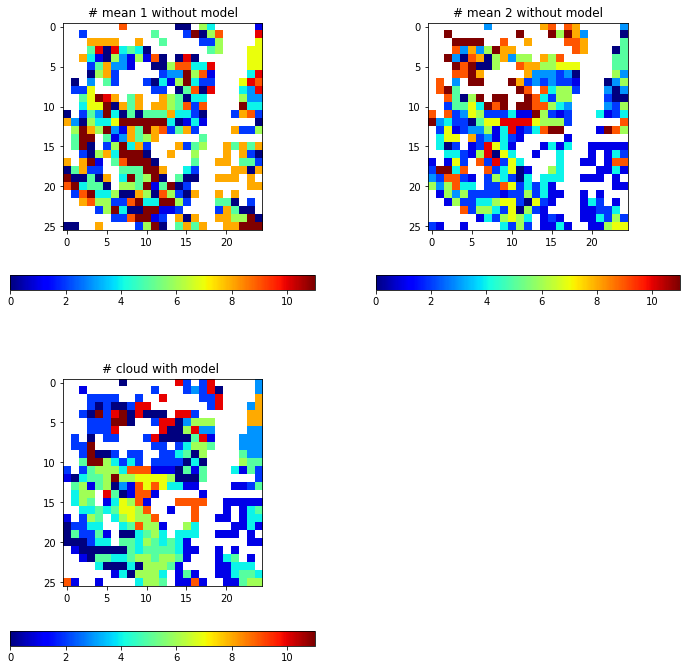

In [45]:
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(221)
plt.imshow(img1_array, cmap='jet')
ax.set_title("# mean 1 without model")
plt.colorbar(orientation='horizontal')
ax = plt.subplot(222)
plt.imshow(img2_array, cmap='jet')
ax.set_title("# mean 2 without model")
plt.colorbar(orientation='horizontal')
fig.tight_layout
ax = plt.subplot(223)
plt.imshow(cimg_array, cmap='jet')
ax.set_title("# cloud with model " )
plt.colorbar(orientation='horizontal')
fig.tight_layout

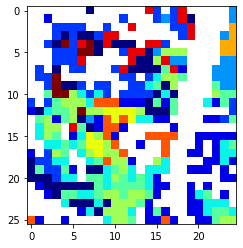

In [46]:
plt.imshow(cimg_array, cmap='jet')

# End of new work
NOTE: Currently downloading mod06 data for the dates I downloaded patches for so waiting to run vizualizations until I have all the data

### MOD06 data
Geophysical Parameters:  
*Cloud Optics  
Cloud particle phase, effective particle size, optical thickness, water path, visible cirrus reflectance  

*Cloud Top  
Cloud top temperature, pressure, emissivity, and height    

###### Optics  
optical thickness  
water path  
particle phase  


###### Top  
pressure  
*(height and temperature is derived from pressure with model data)

In [57]:
hdf_datadir = "/project2/chard/clouds/data/MOD06/20150628"

In [58]:
hdf_filelist=[
    "MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Optical_Thickness.hdf",
    "MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Water_Path.hdf",
    "MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Phase_Infrared.hdf",
    "MOD06_L2.A2015179.mosaic.061.2019122231923.mcgscs_000501331914.Cloud_Top_Pressure.hdf",
]

In [60]:
def mod06_proc_sds(sds_array, variable='sds var'):
    """
    IN: array = hdf_data.select(variable_name)
    """
    array = sds_array.get()
    array = array.astype(np.float64)
    
    # nan process
    nan_idx = np.where( array == sds_array.attributes()['_FillValue'])
    if len(nan_idx) > 0:
        array[nan_idx] = np.nan
    else:
        pass
    
    # radiacne offset
    offset = sds_array.attributes()['add_offset']
    array = array - offset
    
    # radiance scale
    scales = sds_array.attributes()['scale_factor']
    array = array*scales
    
    ### Error Value process
    if variable == 'Cloud_Optical_Thickness':
        err_idx = np.where(array > 100.0) # optical thickness range[0,100] no unit
        array[err_idx] = np.nan
    
    return array

In [61]:
cot_hdf = SD(hdf_datadir+'/'+hdf_filelist[0], SDC.READ)
cwp_hdf = SD(hdf_datadir+'/'+hdf_filelist[1], SDC.READ)
cpi_hdf = SD(hdf_datadir+'/'+hdf_filelist[2], SDC.READ)
ctp_hdf = SD(hdf_datadir+'/'+hdf_filelist[3], SDC.READ)

In [62]:
cot_sds = cot_hdf.select("Cloud_Optical_Thickness")
cwp_sds = cwp_hdf.select("Cloud_Water_Path")
cpi_sds = cpi_hdf.select("Cloud_Phase_Infrared")
ctp_sds = ctp_hdf.select("Cloud_Top_Pressure")

In [63]:
cot_array = mod06_proc_sds(cot_sds, variable="Cloud_Optical_Thickness")
cwp_array = mod06_proc_sds(cwp_sds)
cpi_array = mod06_proc_sds(cpi_sds)
ctp_array = mod06_proc_sds(ctp_sds)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


In [64]:
nx, ny = cot_array.shape
d_list = [
    cot_array.reshape(nx,ny,1),
    cwp_array.reshape(nx,ny,1),
    cpi_array.reshape(nx,ny,1),
    ctp_array.reshape(nx,ny,1),
]

In [65]:
mod06_img = np.concatenate(d_list, axis=2)

###### Development for cloud phase infrared 
compute mode value

In [67]:
mod06_patches = _gen_patches(mod06_img, normalization=False, flag_nan=True)

In [68]:
mod06_patches_mean = np.nanmean(mod06_patches, axis=(2,3))

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


mode computation

In [69]:
prep_phase = copy.deepcopy(mod06_patches[:,:,:,:,2])

###### Function to create `Mode` for cloud phase infrared

In [71]:
_x, _y = mod06_patches.shape[:2]
phase_mode = np.zeros((_x,_y))
for i in range(_x):
    for j in range(_y):
        phase, _= sc.stats.mode(prep_phase[i,j].ravel(), nan_policy='omit')
        phase_mode[i,j] = phase

In [72]:
phase_mode.shape

(35, 37)

CheckIO

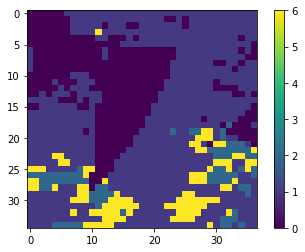

In [74]:
plt.imshow(phase_mode)
plt.colorbar()

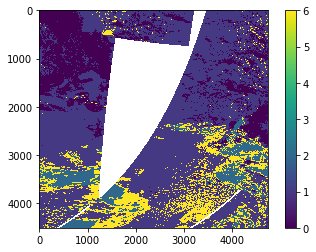

In [75]:
plt.imshow(cpi_array)
plt.colorbar()

Replace value with `NAN` where clouds_xy_list does not have

In [77]:
cpi_modes = np.zeros((_x,_y)).astype(np.float64)
cpi_modes[:,:] = np.nan
for idx, (x,y) in enumerate(clouds_xy_list):
    cpi_modes[x,y] = phase_mode[x,y]

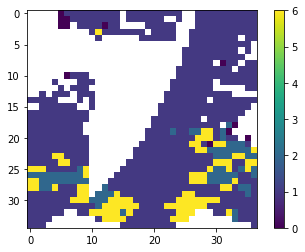

In [78]:
plt.imshow(cpi_modes)
plt.colorbar()

### Stats Analysis
img1_array  
img2_array  
cimg_array

###### NOTE
mode06_patches_mean does not have to go through reconst-array (refer to valid patches wit cloud) process since in compute_patch_stats function, index extractoin take place of this process

In [80]:
mod06_patches_mean.shape, cpi_modes.shape

((35, 37, 4), (35, 37))

In [81]:
mod06_patches_mean[:,:,2] = cpi_modes

In [85]:
def compute_patch_stats(img_array, _mod06_patches_mean, n_cluster=12):
    #intensity = []
    physics = []
    for icluster in range(n_cluster):
        # get index
        cluster_idx = np.where(img_array == icluster)
    
        #image intensity
        #intensity +=[patches_mean[cluster_idx]]
    
        # physics properties
        physics += [_mod06_patches_mean[cluster_idx]]
    return physics

In [88]:
img1_physics = compute_patch_stats(img1_array, mod06_patches_mean, n_cluster=n_cluster)

In [89]:
img2_physics = compute_patch_stats(img2_array, mod06_patches_mean, n_cluster=n_cluster)

In [104]:
cimg_physics = compute_patch_stats(cimg_array, mod06_patches_mean, n_cluster=n_cluster)

#### Physics Distribution 

In [92]:
namelist = [
    "Optical Thickness",
    "Cloud Water Path",
    "Phase (mode)",
    "Cloud Top Pressure"
]

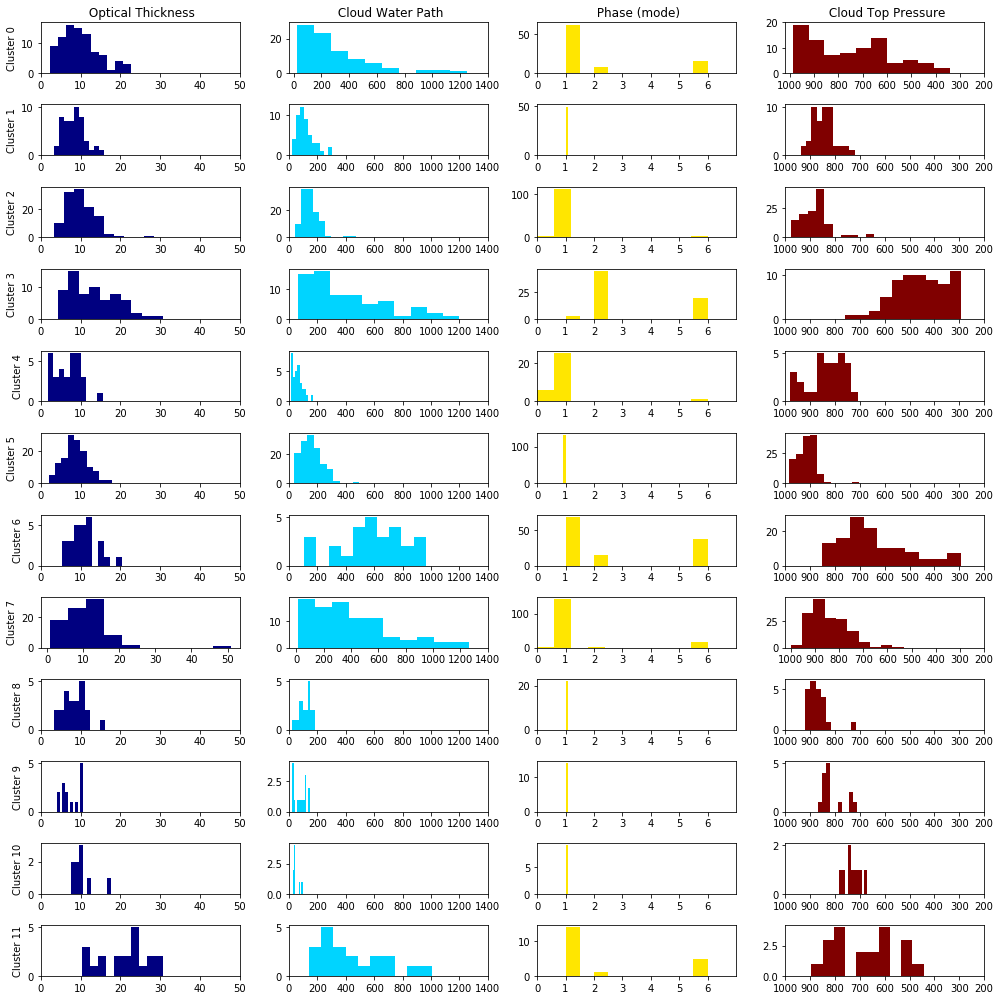

In [137]:
fig = plt.figure(figsize=(14,14))
it = 1
phys_colors = _get_colors(n=4)
for i in range(n_cluster):
    for k in range(4):
        ax = plt.subplot(n_cluster, 4, it)
        #===============================================
        # change here
        #===============================================
        tmp = img1_physics[i][:,k]
        #===============================================
        tmp = tmp[np.logical_not(np.isnan(tmp))]
        plt.hist(tmp, color=phys_colors[k])
        if i == 0:
            ax.set_title(" %s" % namelist[k])   
        if k == 0:
            ax.set_ylabel("Cluster %d" % i)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            ax.set_xticks([l for l in range(0,1500,200)])
        elif k == 2:
            ax.set_xticks([l for l in range(0,7,1)])
            ax.set_xlim(0,7)
        elif k ==3:
            ax.set_xticks([l for l in range(200,1001,100)])
            ax.invert_xaxis()
        it += 1
fig.tight_layout()
plt.show()

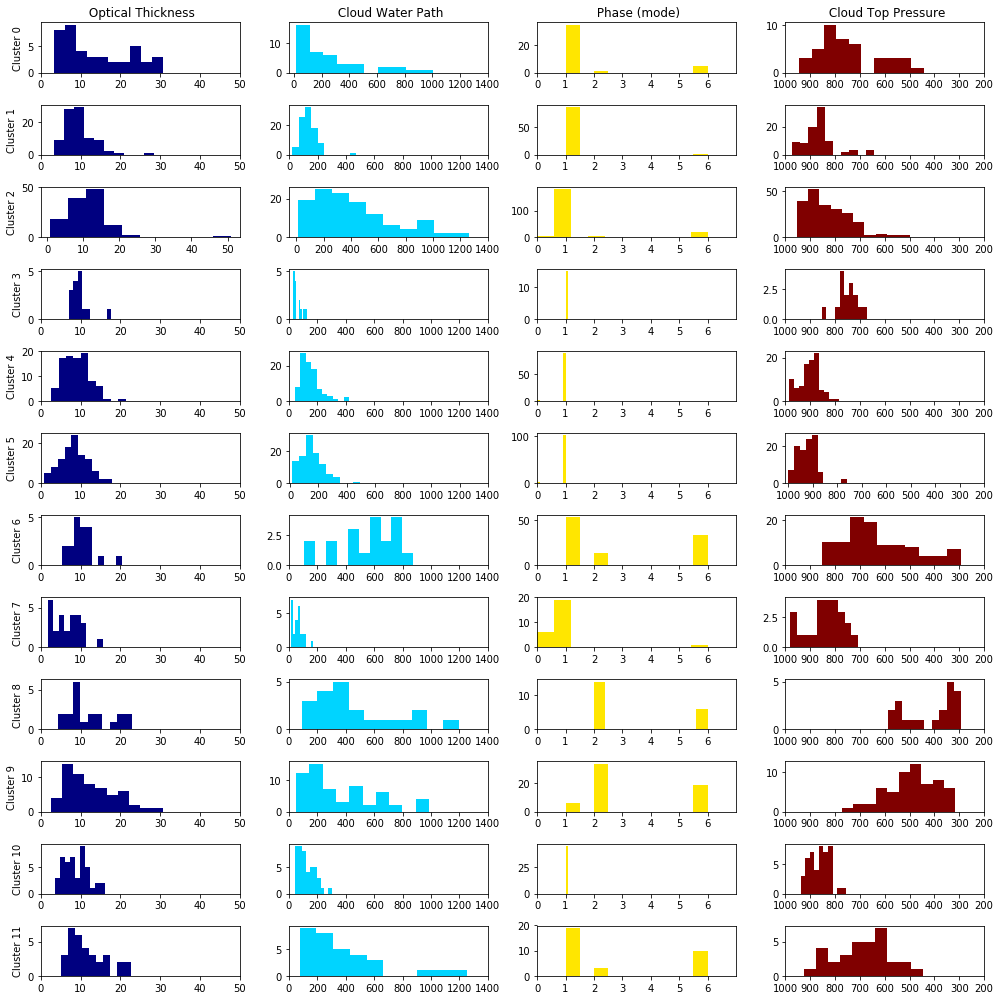

In [136]:
fig = plt.figure(figsize=(14,14))
it = 1
phys_colors = _get_colors(n=4)
for i in range(n_cluster):
    for k in range(4):
        ax = plt.subplot(n_cluster, 4, it)
        #===============================================
        # change here
        #===============================================
        tmp = img2_physics[i][:,k]
        #===============================================
        tmp = tmp[np.logical_not(np.isnan(tmp))]
        plt.hist(tmp, color=phys_colors[k])
        if i == 0:
            ax.set_title(" %s" % namelist[k])   
        if k == 0:
            ax.set_ylabel("Cluster %d" % i)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            ax.set_xticks([l for l in range(0,1500,200)])
        elif k == 2:
            ax.set_xticks([l for l in range(0,7,1)])
            ax.set_xlim(0,7)
        elif k ==3:
            ax.set_xticks([l for l in range(200,1001,100)])
            ax.invert_xaxis()
        it += 1
fig.tight_layout()
plt.show()

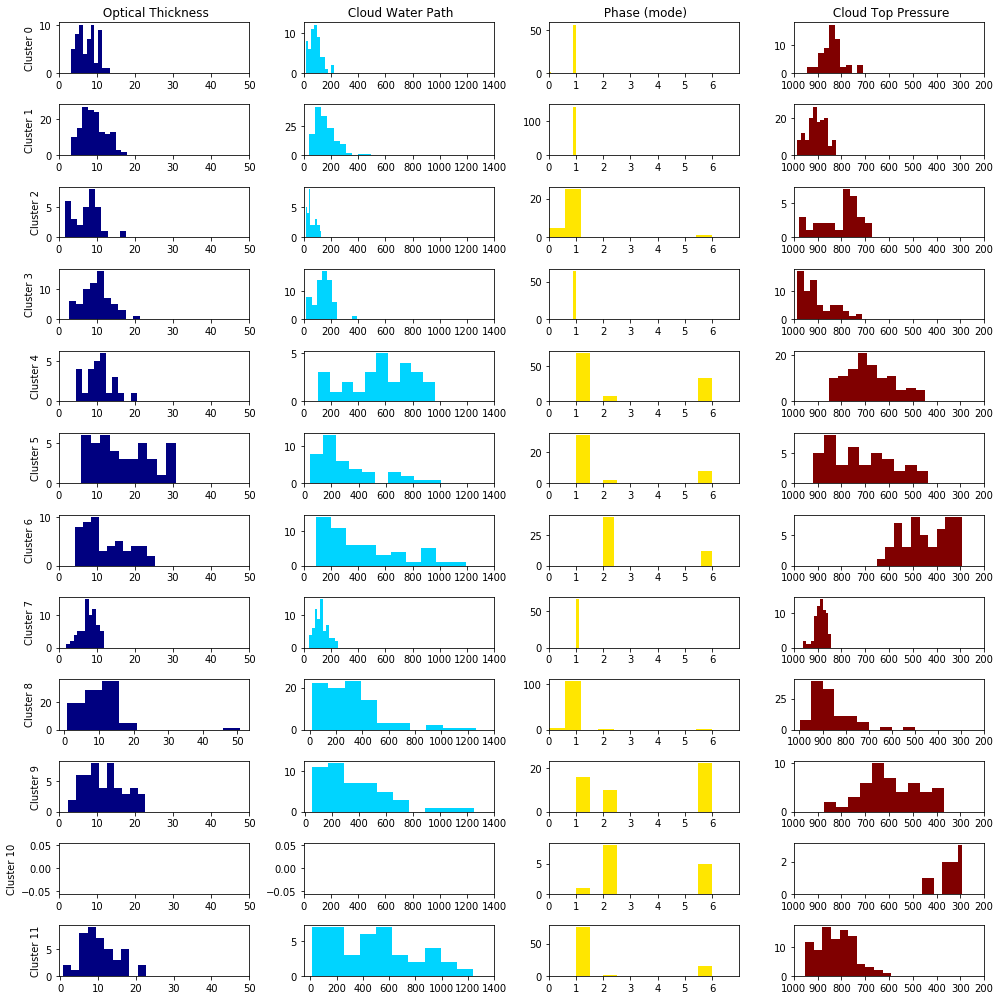

In [135]:
fig = plt.figure(figsize=(14,14))
it = 1
phys_colors = _get_colors(n=4)
for i in range(n_cluster):
    for k in range(4):
        ax = plt.subplot(n_cluster, 4, it)
        #===============================================
        # change here
        #===============================================
        tmp = cimg_physics[i][:,k]
        #===============================================
        tmp = tmp[np.logical_not(np.isnan(tmp))]
        plt.hist(tmp, color=phys_colors[k])
        if i == 0:
            ax.set_title(" %s" % namelist[k])   
        if k == 0:
            ax.set_ylabel("Cluster %d" % i)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            ax.set_xticks([l for l in range(0,1500,200)])
        elif k == 2:
            ax.set_xticks([l for l in range(0,7,1)])
            ax.set_xlim(0,7)
        elif k ==3:
            ax.set_xticks([l for l in range(200,1001,100)])
            ax.invert_xaxis()
        it += 1
fig.tight_layout()
plt.show()

### Visual Check with visible band (band 1)

In [98]:
hdf_datadir = "/project2/chard/clouds/data/MOD02/04"
vis_file = hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_250_Aggr1km_RefSB_1.hdf'
vhdf = SD(vis_file, SDC.READ)
vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")
vhdf_array, vis_band = proc_sds(vhdf_sds)

Process bands 1


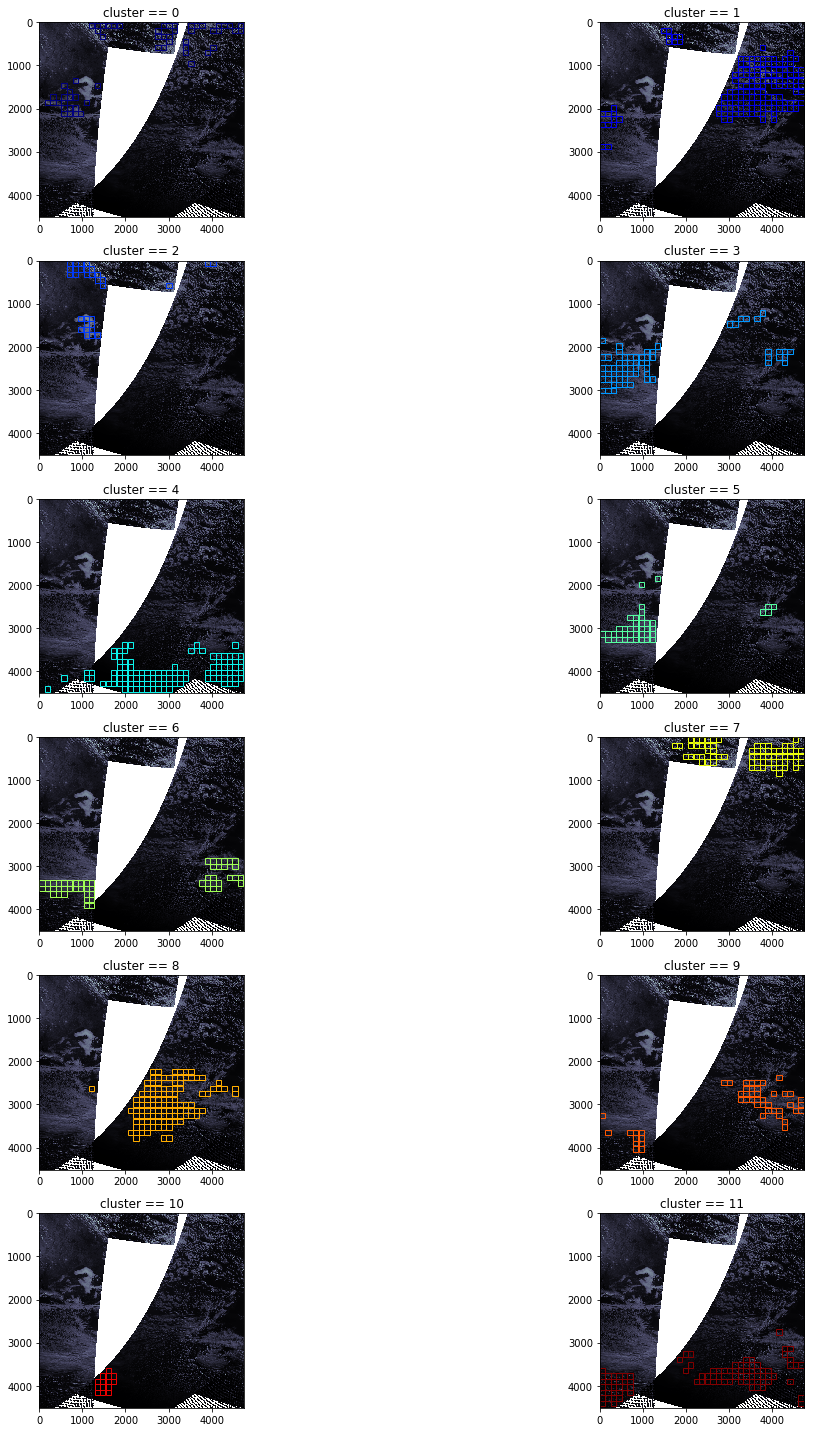

In [106]:
fig = plt.figure(figsize=(20,20))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_cluster)
for idx, icluster in enumerate(range(12)):
    ax = plt.subplot(6,2,idx+1)
    plt.imshow(vhdf_array, cmap='bone')
    ax.set_title("cluster == %d" % idx)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            #==============================================
            if not np.isnan(cimg_array[i,j]):
                if cimg_array[i,j] == icluster:
                    #======================================
                    ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(cimg_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.show()

Geographical DIstribution of MOD06 

In [115]:
_namelist = [
    "Optical Thickness [unit-less]",
    "Cloud Water Path [g/m^2]",
    "Phase [0,1,2,3,6]",
    "Cloud Top Pressure [hpa]"
]

All patches

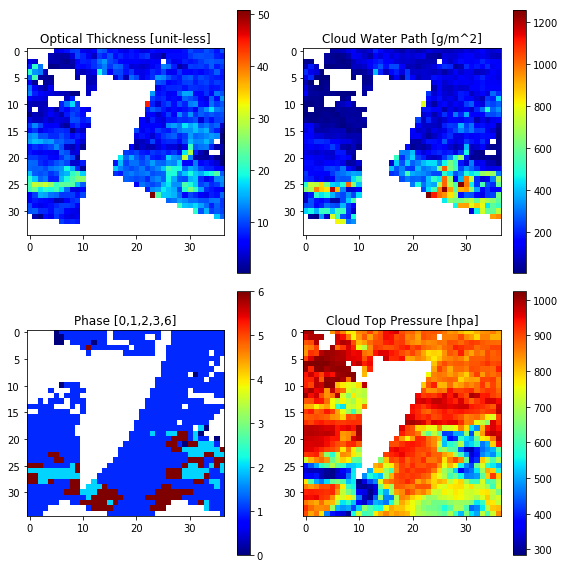

In [116]:
fig = plt.figure(figsize=(8,8))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(mod06_patches_mean[:,:,i], cmap='jet')
    plt.colorbar()
    ax.set_title("%s" % _namelist[idx])
fig.tight_layout()
plt.show()

##### With cloud patches only

In [121]:
mod06_patches_mean.shape

(35, 37, 4)

In [124]:
_xx, _yy, _nvar = mod06_patches_mean.shape
mod06_valid_patches = np.zeros((_xx, _yy, _nvar)).astype(np.float64)
mod06_valid_patches[:,:,:] = np.nan
for (x,y) in clouds_xy_list:
    mod06_valid_patches[x,y,:] = mod06_patches_mean[x,y,:]

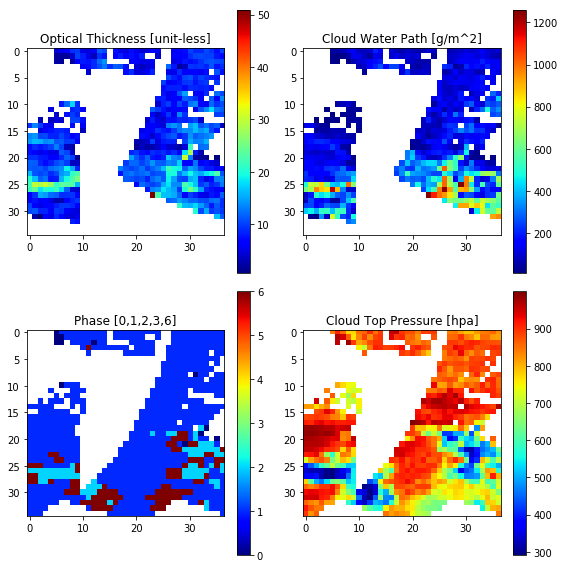

In [125]:
fig = plt.figure(figsize=(8,8))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(mod06_valid_patches[:,:,i], cmap='jet')
    plt.colorbar()
    ax.set_title("%s" % _namelist[idx])
fig.tight_layout()
plt.show()

In [109]:
cot_sds.attributes()

{'valid_range': [0, 10000],
 '_FillValue': -9999,
 'long_name': 'Cloud Optical Thickness two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral',
 'units': 'none',
 'scale_factor': 0.009999999776482582,
 'add_offset': 0.0,
 'Parameter_Type': 'Output',
 'Cell_Along_Swath_Sampling': [1, 2030, 1],
 'Cell_Across_Swath_Sampling': [1, 1354, 1],
 'Geolocation_Pointer': 'External MODIS geolocation product'}

In [110]:
cwp_sds.attributes()

{'valid_range': [0, 10000],
 '_FillValue': -9999,
 'long_name': 'Column Water Path two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um) (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral',
 'units': 'g/m^2',
 'scale_factor': 1.0,
 'add_offset': 0.0,
 'Parameter_Type': 'Output',
 'Cell_Along_Swath_Sampling': [1, 2030, 1],
 'Cell_Across_Swath_Sampling': [1, 1354, 1],
 'Geolocation_Pointer': 'External MODIS geolocation product'}

In [111]:
cpi_sds.attributes()

{'valid_range': [-128, 127],
 '_FillValue': 127,
 'long_name': 'Cloud Phase from 8.5 and 11 um Bands',
 'units': 'none',
 'scale_factor': 1.0,
 'add_offset': 0.0,
 'Parameter_Type': 'Output',
 'Cell_Along_Swath_Sampling': [3, 2028, 5],
 'Cell_Across_Swath_Sampling': [3, 1348, 5],
 'Geolocation_Pointer': 'Internal geolocation arrays',
 'description': '\\n                                                                                  \n                                                                                    \n The values in this SDS indicate the following cloud phase:                         \n 0 -- cloud free                                                                    \n 1 -- water cloud                                                                   \n 2 -- ice cloud                                                                     \n 3 -- mixed phase cloud                                                             \n 6 -- undetermined phase                    

In [112]:
ctp_sds.attributes()

{'valid_range': [10, 11000],
 '_FillValue': -32768,
 'long_name': 'Cloud Top Pressure Level (rounded to nearest 5 mb)',
 'units': 'hPa',
 'scale_factor': 0.10000000149011612,
 'add_offset': 0.0,
 'Parameter_Type': 'Output',
 'Cell_Along_Swath_Sampling': [3, 2028, 5],
 'Cell_Across_Swath_Sampling': [3, 1348, 5],
 'Geolocation_Pointer': 'Internal geolocation arrays'}

### Visual Check for without-model images
img1_array  
img2_array

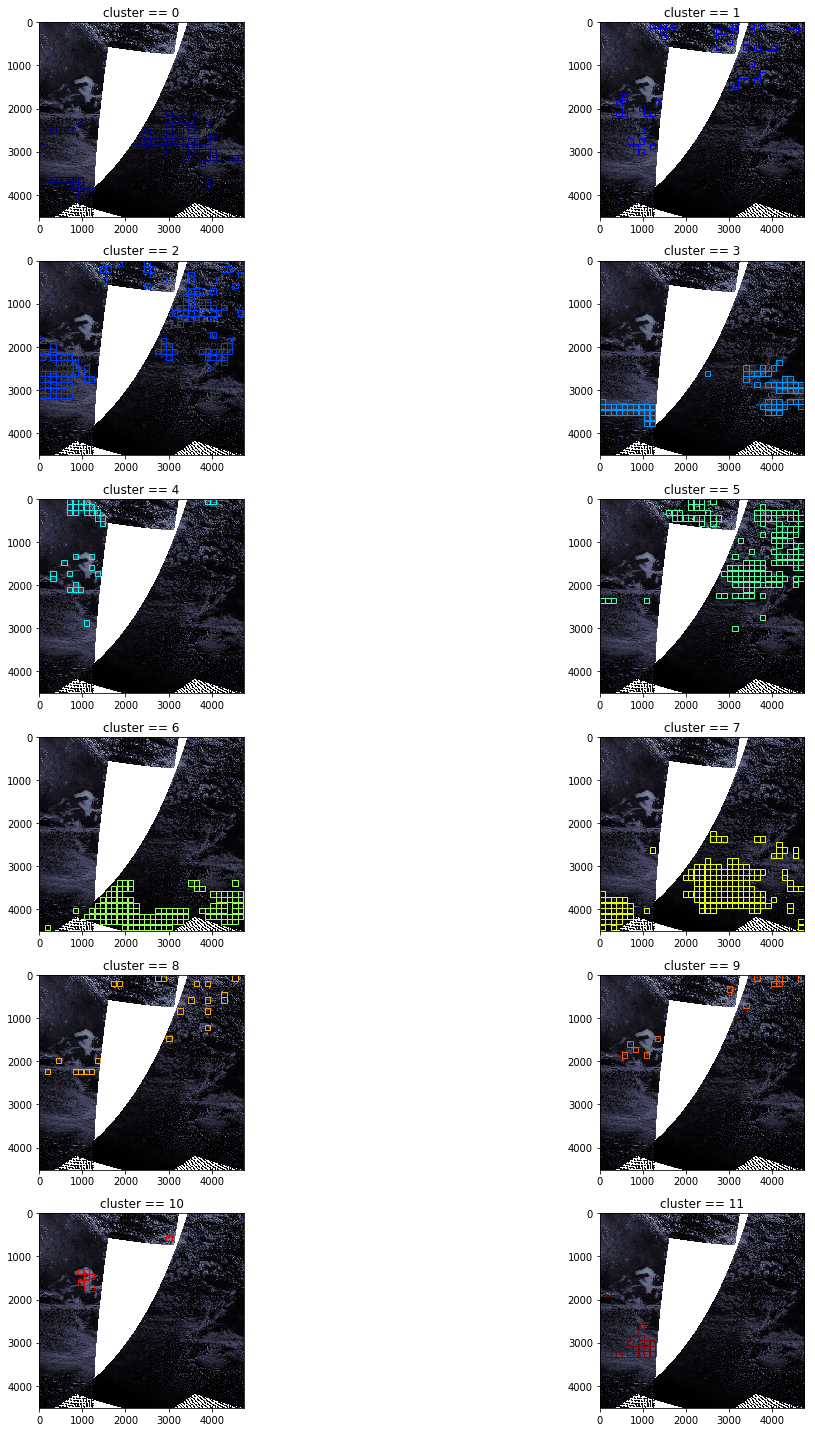

In [117]:
fig = plt.figure(figsize=(20,20))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_cluster)
for idx, icluster in enumerate(range(12)):
    ax = plt.subplot(6,2,idx+1)
    plt.imshow(vhdf_array, cmap='bone')
    ax.set_title("cluster == %d" % idx)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            #==============================================
            if not np.isnan(img1_array[i,j]):
                if img1_array[i,j] == icluster:
                    #======================================
                    ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(img1_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.show()

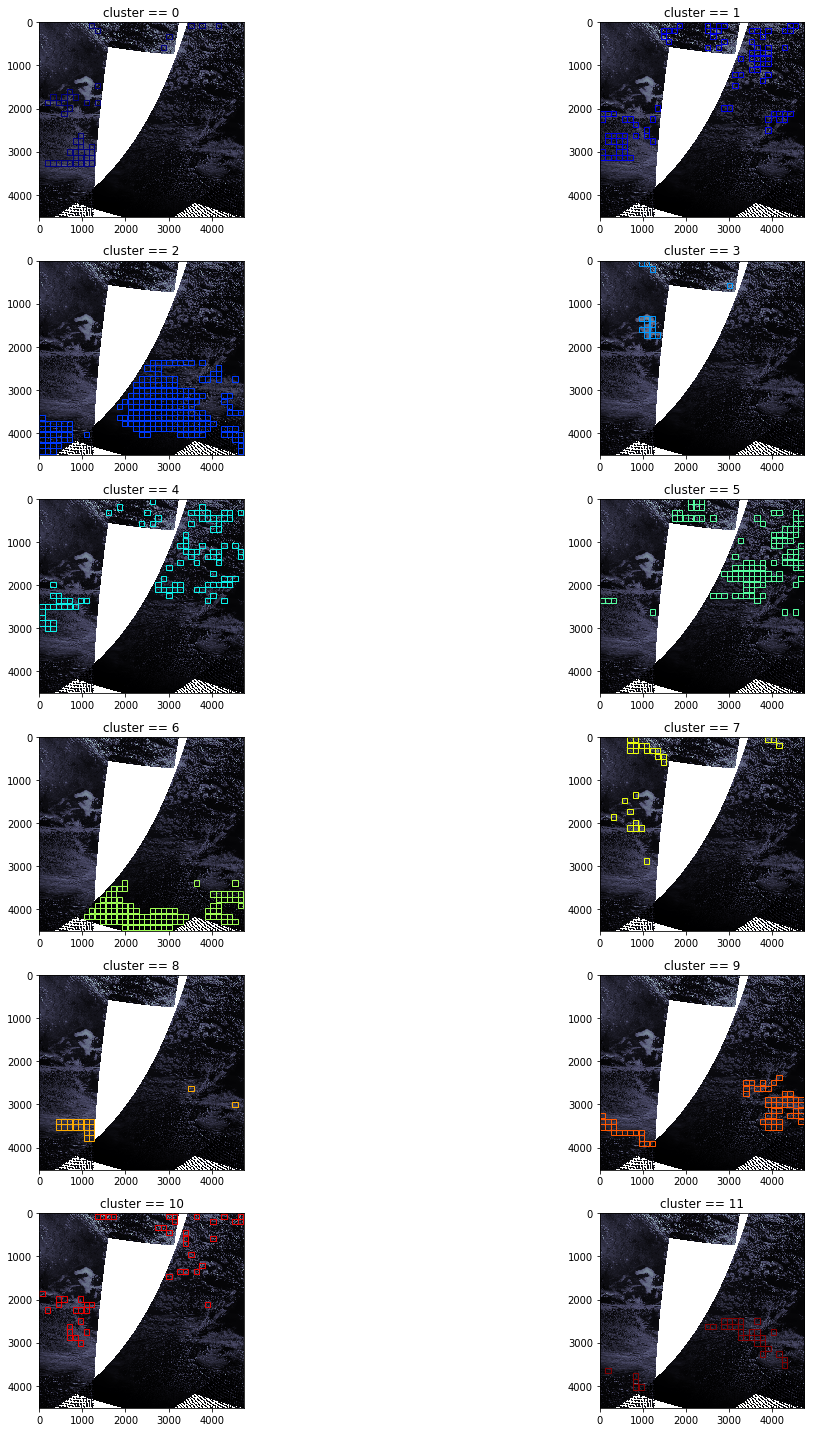

In [118]:
fig = plt.figure(figsize=(20,20))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_cluster)
for idx, icluster in enumerate(range(12)):
    ax = plt.subplot(6,2,idx+1)
    plt.imshow(vhdf_array, cmap='bone')
    ax.set_title("cluster == %d" % idx)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            #==============================================
            if not np.isnan(img2_array[i,j]):
                if img2_array[i,j] == icluster:
                    #======================================
                    ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(img2_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.show()

#### mod02 with cloud patches

In [126]:
mod02_patches_mean = np.nanmean(patches, axis=(2,3))

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [127]:
_xx, _yy, _nvar = mod02_patches_mean.shape
mod02_valid_patches = np.zeros((_xx, _yy, _nvar)).astype(np.float64)
mod02_valid_patches[:,:,:] = np.nan
for (x,y) in clouds_xy_list:
    mod02_valid_patches[x,y,:] = mod02_patches_mean[x,y,:]

In [129]:
m02_namelist = [
    "bands 6 [w/m^2/micro m/st]",
    "bands 7 [w/m^2/micro m/st]",
    "bands 20 [w/m^2/micro m/st]",
    "bands 28 [w/m^2/micro m/st]",
    "bands 29 [w/m^2/micro m/st]",
    "bands 31 [w/m^2/micro m/st]",
]

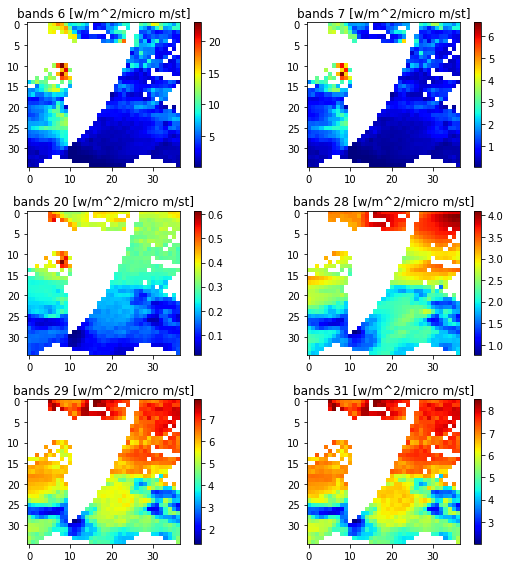

In [130]:
fig = plt.figure(figsize=(8,8))
for idx, i in enumerate(range(6)):
    ax = plt.subplot(3,2,idx+1)
    plt.imshow(mod02_valid_patches[:,:,i], cmap='jet')
    plt.colorbar()
    ax.set_title("%s" % m02_namelist[idx])
fig.tight_layout()
plt.show()

In [132]:
cimg_physics[0].shape

(57, 4)

In [134]:
cimg_physics[0][:,2]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

---------------------
#### Strength of input array

In [35]:
cimg_array.shape

(35, 37)

In [36]:
mod02_img.shape

(4513, 4748, 6)

In [37]:
mo02_patches = _gen_patches(mod02_img, normalization=False)

In [38]:
mo02_patches.shape

(35, 37, 128, 128, 6)

In [41]:
m02_array = np.nanmean(mo02_patches, axis=(2,3,4))

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [42]:
m02_array.shape

(35, 37)

In [43]:
## intensity

intensity = []
for icluster in range(n_cluster):
    # get index
    cluster_idx = np.where(cimg_array == icluster)
    
    #image intensity
    intensity +=[m02_array[cluster_idx]]

In [45]:
np.asarray(intensity).shape

(12,)

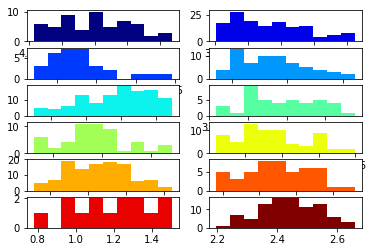

In [49]:
colors = _get_colors(n=12)
fig = plt.figure()
for idx, i in enumerate(intensity) :
    ax = plt.subplot(6,2,idx+1 )
    plt.hist(i, color=colors[idx] )
fig.tight_layout
plt.show()

Text(0, 0.5, 'Numer of patches')

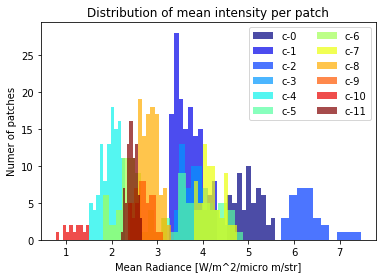

In [57]:
for idx, i in enumerate(intensity) :
    plt.hist(i, color=colors[idx], alpha=0.7, label='c-'+str(idx))
plt.legend(loc='upper right', ncol=2)
plt.title('Distribution of mean intensity per patch')
plt.xlabel('Mean Radiance [W/m^2/micro m/str]')
plt.ylabel('Numer of patches')